In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CompressTree import CompressTree
from numpy.linalg import svd
from  timeit import default_timer as timer
from TreeDraw import draw_tree
import cv2

In [2]:
def gen_mat_with_zeros(how_many_zeros: float, size = 2 **10) -> np.ndarray:
    X = np.random.random((size,size))
    P = np.random.random((size,size))
    return (P > how_many_zeros).astype(int) * X

In [3]:
def measure_algorithms():
    results = []
    sigmas = []
    for p in [0.99,0.98, 0.95, 0.9, 0.8]:
        mat = gen_mat_with_zeros(p)
        U, Sigma, V = svd(mat)
        sigmas.append([p, Sigma])
        for b in [1, 4]:
            for s in [0,len(Sigma)//2 - 1, len(Sigma)-1]:
                root = CompressTree(mat, 0, len(mat), 0, len(mat[0]))
                start = timer()
                root.create_tree(b, Sigma[s])
                end = timer()
                draw_tree(root, f"zer jest {p}, b wynosi {b}, indeks sigmy {s}")
                decompressed = np.zeros((2**10, 2**10))
                root.decompress(decompressed)
                results.append([p, s, Sigma[s],root.compare(decompressed), end-start])
    df = pd.DataFrame(results, columns=["ile zer", "sigma index", "sigma","błąd", "czas wykonania"])
    df_sigmas = pd.DataFrame(sigmas, columns=["ile zer", "sygmy"])
    return df, df_sigmas

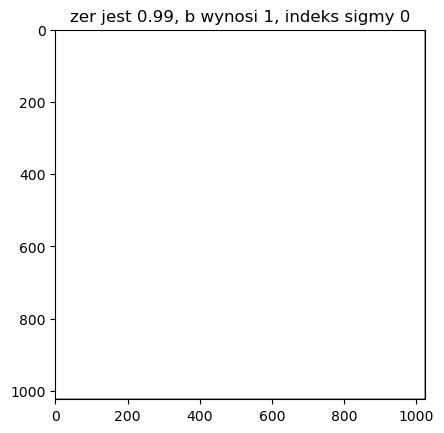

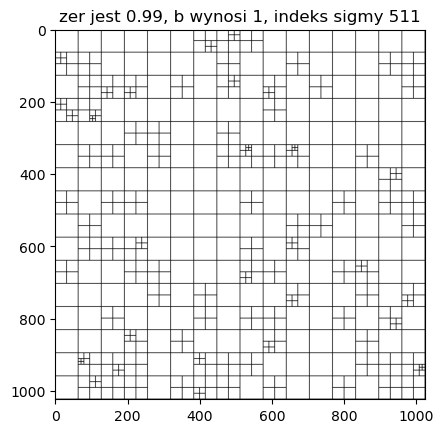

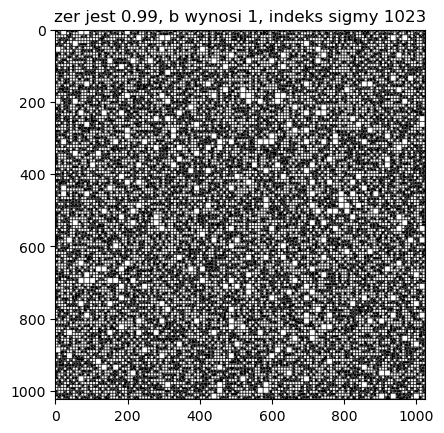

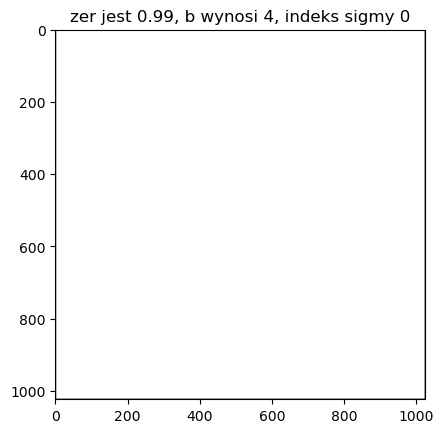

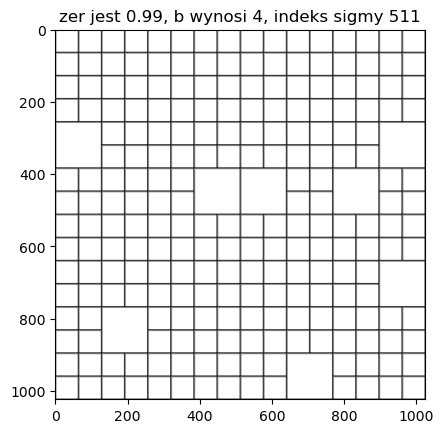

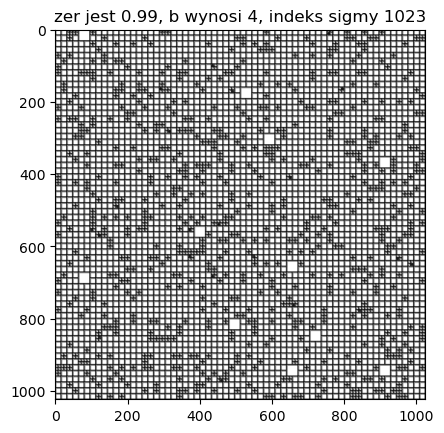

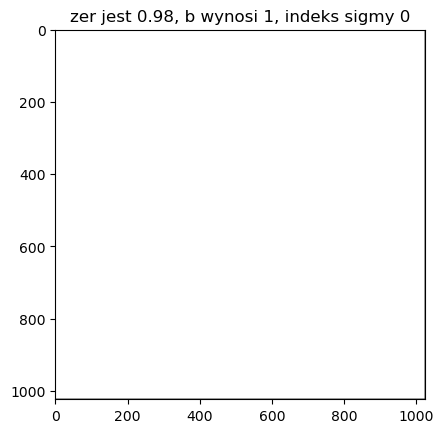

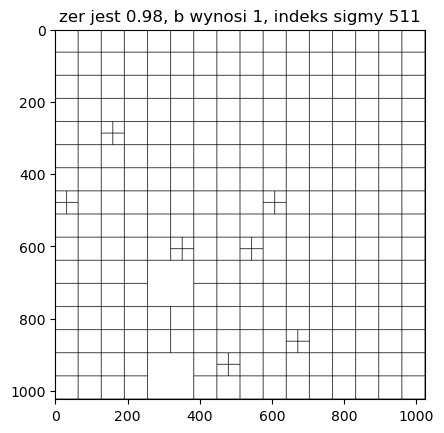

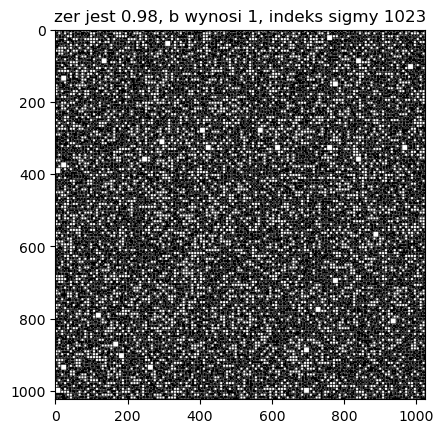

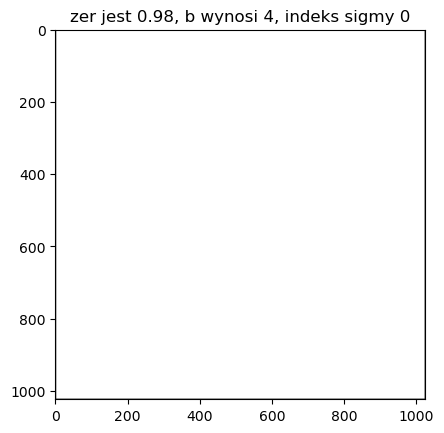

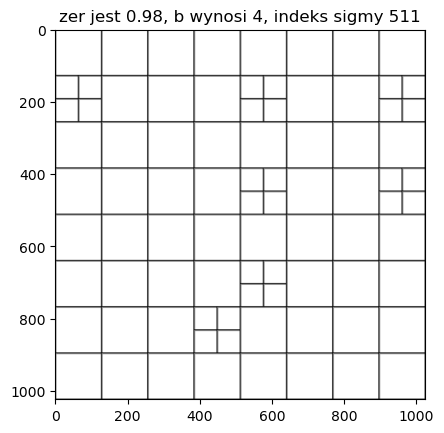

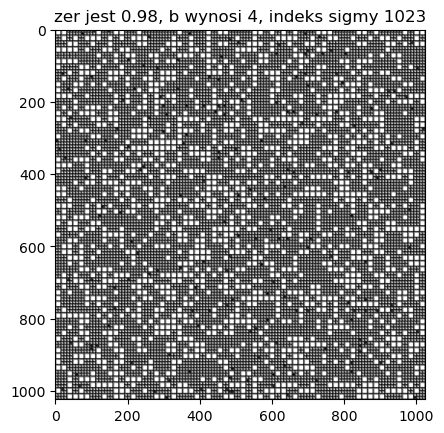

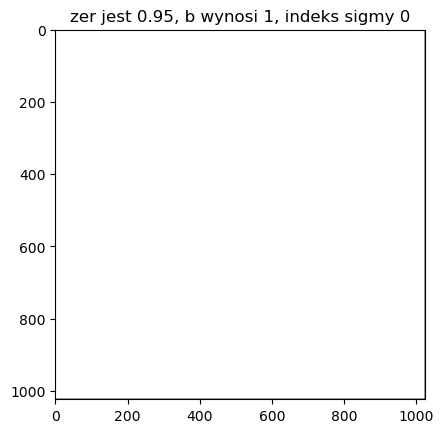

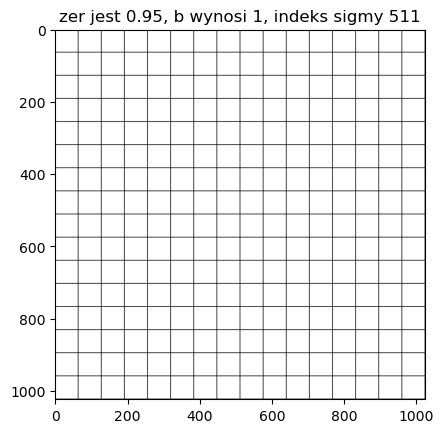

KeyboardInterrupt: 

In [4]:
df, df_sigmas = measure_algorithms()

df = pd.read_csv("./dataframes/meserments.csv", header=0).drop("n", axis=1)

(1024, 1024, 3)


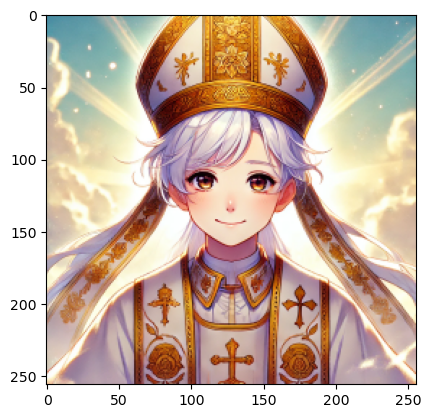

In [18]:
image = cv2.imread("papaj.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
image_arr = np.array(image)
print(image_arr.shape)
# plt.imshow(image)
image_arr = cv2.resize(image_arr, (256, 256), interpolation=cv2.INTER_AREA)
image_arr.shape
plt.imshow(image_arr)

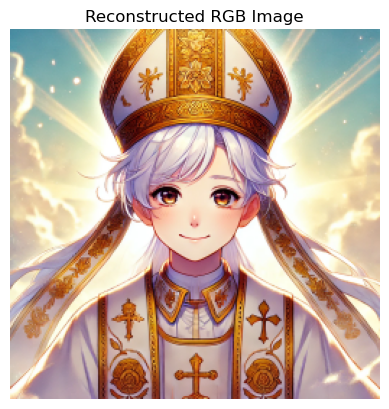

In [6]:
red_channel = image_arr[:, :, 0]
green_channel = image_arr[:, :, 1]
blue_channel = image_arr[:, :, 2]
red_channel = red_channel.astype(np.uint8)
green_channel = green_channel.astype(np.uint8)
blue_channel = blue_channel.astype(np.uint8)
rgb_image = np.stack((red_channel, green_channel, blue_channel), axis=2)

# Display the RGB image
plt.imshow(rgb_image.astype(np.uint8))  # Ensure values are in [0, 255] and of type uint8
plt.axis('off')
plt.title("Reconstructed RGB Image")
plt.show()



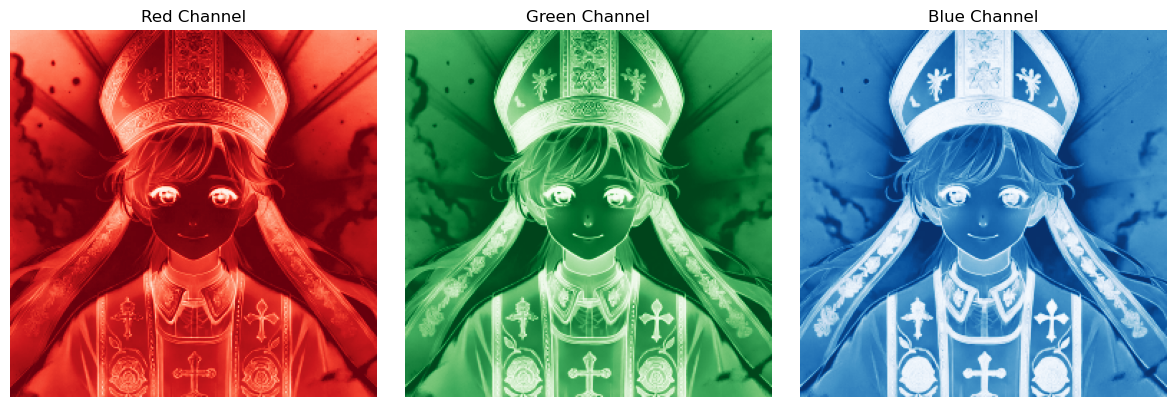

In [7]:
plt.figure(figsize=(12, 4))

# Display the Red channel
plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

# Display the Green channel
plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

# Display the Blue channel
plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
def compress_and_draw_channel(channel, channel_name):
    # Initialize the compression tree
    root = CompressTree(channel, 0, len(channel), 0, len(channel[0]))
    
    # Perform SVD to determine the compression threshold (epsilon)
    U, Sigma, V = svd(channel)
    epsilon = Sigma[10]
    
    # Build the compression tree
    root.create_tree(1, epsilon)
    
    # Prepare a matrix for decompression
    decompressed_channel = np.zeros_like(channel)
    root.decompress(decompressed_channel)
    
    # Display the original channel, decompressed channel, and compressed visualization
    plt.figure(figsize=(12, 4))
    
    # Show the original channel
    plt.subplot(1, 3, 1)
    plt.imshow(channel, cmap=channel_name)
    plt.title(f'Original {channel_name} Channel')
    plt.axis('off')
    
    # Show the decompressed channel
    plt.subplot(1, 3, 2)
    plt.imshow(decompressed_channel, cmap=channel_name)
    plt.title(f'Decompressed {channel_name} Channel')
    plt.axis('off')
    
    # Show the compressed visualization using the draw_tree function
    plt.subplot(1, 3, 3)
    draw_tree(root, title=f'Compressed {channel_name} Visualization')
    plt.tight_layout()
    plt.show()

    return decompressed_channel


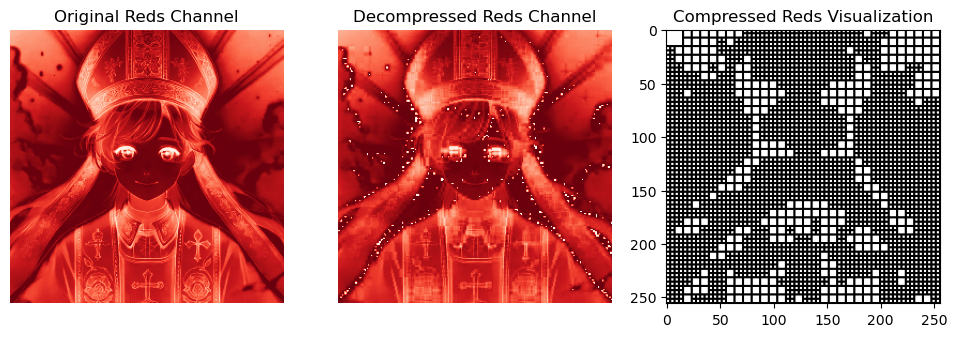

<Figure size 640x480 with 0 Axes>

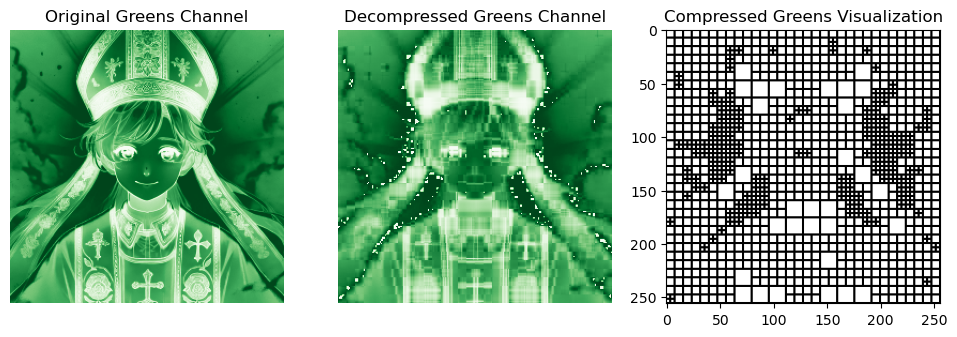

<Figure size 640x480 with 0 Axes>

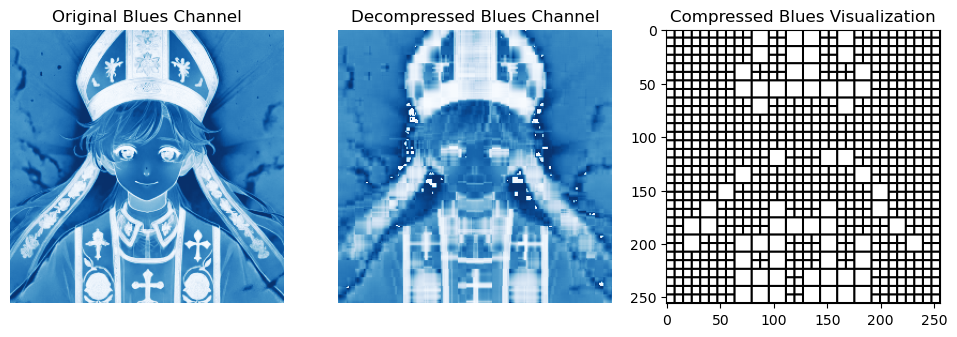

<Figure size 640x480 with 0 Axes>

In [23]:
red = compress_and_draw_channel(red_channel, 'Reds')
green = compress_and_draw_channel(green_channel, 'Greens')
blue = compress_and_draw_channel(blue_channel, 'Blues')

In [26]:
def before_after_size(channel):
    before_channel = globals().get(channel + "_channel")
    after_channel = globals().get(channel)
    return f"\n{channel}\nBefore: {before_channel.size - np.count_nonzero(before_channel)}, After: {after_channel.size - np.count_nonzero(after_channel)}"


print(f"Compression results (number of compressed bytes):\n{before_after_size("red")}\n{before_after_size("green")}\n{before_after_size("blue")}")

Compression results (number of compressed bytes):

red
Before: 0, After: 175

green
Before: 7, After: 159

blue
Before: 9, After: 126


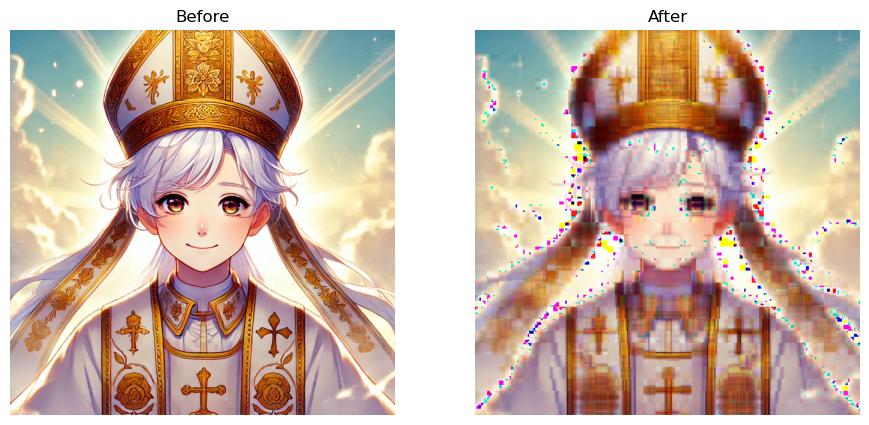

In [21]:
after_img = np.concatenate([red[:, :, np.newaxis], green[:, :, np.newaxis], blue[:, :, np.newaxis]], axis=2)
fig, (before, after) = plt.subplots(1, 2, figsize=(11, 5))
before.axis('off')
after.axis('off')
before.imshow(image)
before.set_title("Before")
after.imshow(after_img)
after.set_title("After")
plt.show()